# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#Yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.features.pca import PCADecomposition

C:\Users\lzapa\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Reading Dataset

In [2]:
rain = pd.read_csv('./data/rain_data_aus.csv')

#Dataset Backup
rain_b = rain.copy

## Displaying all columns

In [3]:
pd.options.display.max_columns = None

# Class & Functions

## Update Score Dataframe

In [4]:
#BaseLine DataFrame
def scores(Column, score, precision, recall):
    '''
    Append a new colum of scores into a dataframe of scores, use it to compare your models.
    
    Columns: Name of the columns/model
    score: Accuracy score
    precision: Precision Score
    recall: Recall Score
    '''
    
    df = pd.DataFrame({Column : [score,precision,recall]}, index=['SCORE', 'PRECISION', 'RECALL'])
    x = pd.concat([rain_scores, df], axis = 1)
    return x

# Exploratory Data Analysis

The first thing first we checked was all NaN data.

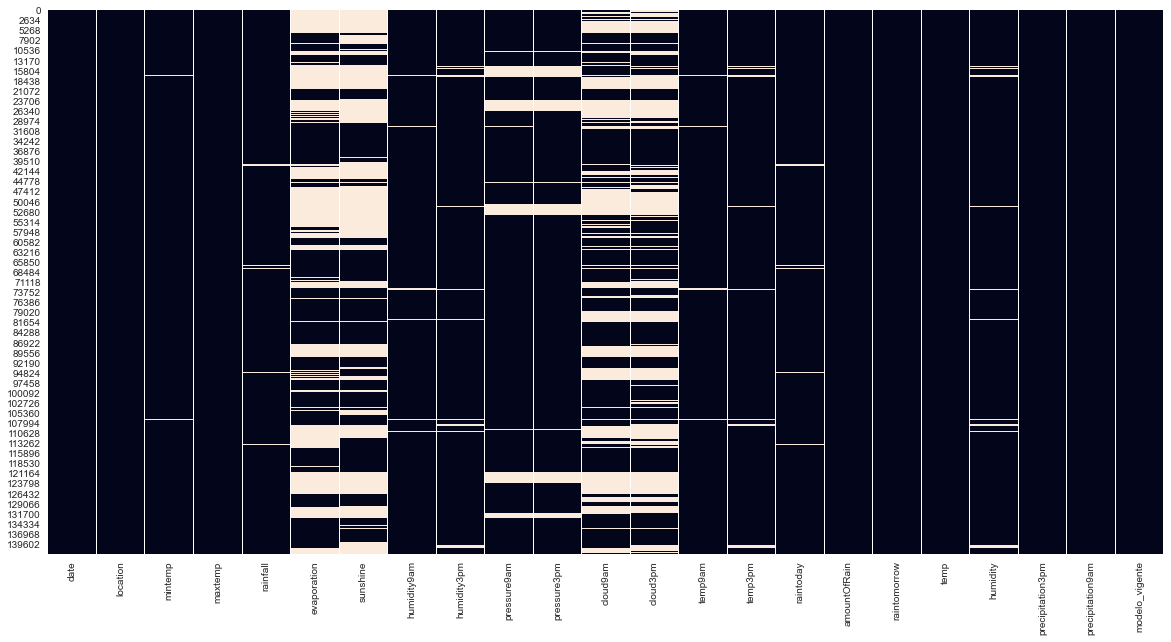

In [5]:
#Heatmap of nulls
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain.isnull(), cbar=False);

In [6]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
date                142193 non-null object
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            140787 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           140787 non-null object
amountOfRain        142193 non-null float64
raintomorrow        142193 non-null object
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm 

In [7]:
rain.isna().sum()

date                    0
location                0
mintemp               637
maxtemp               322
rainfall             1406
evaporation         60843
sunshine            67816
humidity9am          1774
humidity3pm          3610
pressure9am         14014
pressure3pm         13981
cloud9am            53657
cloud3pm            57094
temp9am               904
temp3pm              2726
raintoday            1406
amountOfRain            0
raintomorrow            0
temp                  322
humidity             3610
precipitation3pm        0
precipitation9am        0
modelo_vigente          0
dtype: int64

There are 4 object columns: 

In [8]:
rain.select_dtypes(include='object').columns

Index(['date', 'location', 'raintoday', 'raintomorrow'], dtype='object')

Looking for missing values

In [9]:
rain.isnull().sum()

date                    0
location                0
mintemp               637
maxtemp               322
rainfall             1406
evaporation         60843
sunshine            67816
humidity9am          1774
humidity3pm          3610
pressure9am         14014
pressure3pm         13981
cloud9am            53657
cloud3pm            57094
temp9am               904
temp3pm              2726
raintoday            1406
amountOfRain            0
raintomorrow            0
temp                  322
humidity             3610
precipitation3pm        0
precipitation9am        0
modelo_vigente          0
dtype: int64

# Simple Baseline

Then we decided to do a simple baseline so we can run the logistic regression

## Treating missing values

Let's drop the columns with high missing values. We decided to drop the columns that have more than 1/3 of missing values

In [10]:
nan = rain.isnull().sum()
cols_to_drop = []

for i, value in enumerate(nan.values):
    if value > rain.shape[0]/3:
        cols_to_drop.append(nan.index[i])
        
cols_to_drop

['evaporation', 'sunshine', 'cloud9am', 'cloud3pm']

In [11]:
#Droping columns
rain = rain.drop(cols_to_drop, axis=1)

Looking at other columns with nulls data we founded pressure9am and pressure3pm

In [12]:
#Almost 10% of null values
rain['pressure9am'].isnull().value_counts(normalize=True)

False    0.901444
True     0.098556
Name: pressure9am, dtype: float64

In [13]:
#Almost 10% of null values too
rain['pressure3pm'].isnull().value_counts(normalize=True)

False    0.901676
True     0.098324
Name: pressure3pm, dtype: float64

In [14]:
rain.groupby(by= 'location')[['pressure9am', 'pressure3pm']].describe()

pressure9am                                                   \
                       count         mean       std    min       25%      50%   
location                                                                        
Adelaide              3082.0  1018.727579  7.357987  982.3  1013.700  1018.70   
Albany                2991.0  1018.283049  7.251447  989.2  1013.600  1018.50   
Albury                3011.0  1018.367253  7.361457  989.8  1013.400  1018.40   
AliceSprings          3030.0  1016.699670  6.409189  997.7  1011.725  1016.70   
BadgerysCreek         2785.0  1018.450880  7.014221  996.8  1013.900  1018.60   
Ballarat              3004.0  1017.855293  7.611270  989.4  1012.900  1017.90   
Bendigo               3020.0  1018.024272  7.448458  989.5  1013.000  1018.10   
Brisbane              3161.0  1018.246947  5.461651  997.8  1014.600  1018.30   
Cairns                2988.0  1014.154284  4.183403  994.4  1011.400  1014.70   
Canberra              3194.0  1018.986725  7.492871  987.4  1013.925  1018.90   
Cobar                 2961.0  1017.995137  6.462880  991.7  1013.300  1017.90   
CoffsHarbour          2688.0  1018.222731  6.076822  998.3  1014.100  1018.30   
Dartmoor              2942.0  1017.997621  7.962654  986.2  1012.800  1018.20   
Darwin                3191.0  1011.888154  3.355192  996.3  1009.600  1012.20   
GoldCoast             2980.0  1017.932081  5.457297  999.5  1014.200  1017.90   
Hobart                3187.0  1014.526828  9.964205  982.2  1008.200  1015.40   
Katherine             1558.0  1012.840244  3.797706  998.9  1010.125  1013.00   
Launceston            1882.0  1015.666578  9.238052  985.0  1009.900  1016.35   
Melbourne             2434.0  1017.732580  7.834652  988.9  1012.625  1018.00   
MelbourneAirport      3009.0  1018.087670  7.682523  989.7  1013.100  1018.30   
Mildura               3003.0  1018.771029  7.053044  991.3  1013.900  1018.70   
Moree                 2854.0  1018.309706  5.952067  999.0  1014.000  1018.30   
MountGambier          3029.0  1017.940112  7.934820  985.1  1012.800  1018.20   
MountGinini              0.0          NaN       NaN    NaN       NaN      NaN   
Newcastle                0.0          NaN       NaN    NaN       NaN      NaN   
Nhil                  1569.0  1018.546335  7.543523  986.9  1013.500  1018.50   
NorahHead             2917.0  1018.259033  6.732356  996.5  1013.900  1018.30   
NorfolkIsland         2956.0  1017.631360  5.510219  980.5  1014.200  1018.00   
Nuriootpa             2995.0  1018.915793  7.154657  982.0  1014.100  1018.80   
PearceRAAF            2744.0  1017.746902  6.311765  996.9  1013.200  1017.50   
Penrith                  0.0          NaN       NaN    NaN       NaN      NaN   
Perth                 3192.0  1017.784398  6.523240  996.2  1013.100  1017.40   
PerthAirport          3007.0  1017.890323  6.429501  996.7  1013.300  1017.60   
Portland              2984.0  1017.686260  8.091115  986.7  1012.400  1018.10   
Richmond              2931.0  1018.705527  7.028448  997.0  1014.100  1018.80   
Sale                  2986.0  1017.827294  8.020095  989.3  1012.700  1018.20   
SalmonGums               0.0          NaN       NaN    NaN       NaN      NaN   
Sydney                3317.0  1018.346156  7.021571  986.7  1013.700  1018.60   
SydneyAirport         2997.0  1018.360594  6.979996  996.3  1013.800  1018.50   
Townsville            3033.0  1015.173129  4.590418  994.3  1012.000  1015.60   
Tuggeranong           2983.0  1018.521623  7.571827  992.8  1013.300  1018.40   
Uluru                 1518.0  1017.109881  6.437819  994.6  1012.300  1017.10   
WaggaWagga            2976.0  1018.569120  7.077536  991.5  1013.700  1018.40   
Walpole               2817.0  1017.845651  7.099440  988.9  1013.300  1018.10   
Watsonia              2999.0  1018.035178  7.701749  989.7  1012.950  1018.20   
Williamtown           2543.0  1018.365906  6.579661  997.8  1014.000  1018.50   
Witchcliffe           2819.0  1018.473643  6.701

Grouping by location we can see that some cities do not record the values of these features. Despite the possible relevance of these features, we decided to drop the columns to make a baseline and later we will check these columns. We chose to drop the columns instead of the rows because by dropping the rows we could lose all values for those cities.

In [15]:
rain = rain.drop(['pressure9am','pressure3pm'], axis=1)

In [16]:
rain.isnull().sum()

date                   0
location               0
mintemp              637
maxtemp              322
rainfall            1406
humidity9am         1774
humidity3pm         3610
temp9am              904
temp3pm             2726
raintoday           1406
amountOfRain           0
raintomorrow           0
temp                 322
humidity            3610
precipitation3pm       0
precipitation9am       0
modelo_vigente         0
dtype: int64

In [17]:
rainrows_after = rain.shape[0]

Now let's drop the rows that contain missing values

In [18]:
rain = rain.dropna()

In [19]:
rain.shape

(136489, 17)

In [20]:
lost_rows = rainrows_after - rain.shape[0]
lost_rows

5704

5704 list lines

Let's check if there are still any missing values

In [21]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136489 entries, 0 to 142192
Data columns (total 17 columns):
date                136489 non-null object
location            136489 non-null object
mintemp             136489 non-null float64
maxtemp             136489 non-null float64
rainfall            136489 non-null float64
humidity9am         136489 non-null float64
humidity3pm         136489 non-null float64
temp9am             136489 non-null float64
temp3pm             136489 non-null float64
raintoday           136489 non-null object
amountOfRain        136489 non-null float64
raintomorrow        136489 non-null object
temp                136489 non-null float64
humidity            136489 non-null float64
precipitation3pm    136489 non-null int64
precipitation9am    136489 non-null float64
modelo_vigente      136489 non-null float64
dtypes: float64(12), int64(1), object(4)
memory usage: 18.7+ MB


## Treating object columns

In [22]:
rain.select_dtypes(include='object').columns

Index(['date', 'location', 'raintoday', 'raintomorrow'], dtype='object')

Transform date into datetime values

In [23]:
rain['date'] = pd.to_datetime(rain.date)

Transform binary values of 'raintoday' and 'raintomorrow' into 0 and 1

In [24]:
rain['raintoday'] = rain.raintoday.apply(lambda x: 0 if x == 'No' else 1)

In [25]:
rain['raintomorrow'] = rain.raintomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [26]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136489 entries, 0 to 142192
Data columns (total 17 columns):
date                136489 non-null datetime64[ns]
location            136489 non-null object
mintemp             136489 non-null float64
maxtemp             136489 non-null float64
rainfall            136489 non-null float64
humidity9am         136489 non-null float64
humidity3pm         136489 non-null float64
temp9am             136489 non-null float64
temp3pm             136489 non-null float64
raintoday           136489 non-null int64
amountOfRain        136489 non-null float64
raintomorrow        136489 non-null int64
temp                136489 non-null float64
humidity            136489 non-null float64
precipitation3pm    136489 non-null int64
precipitation9am    136489 non-null float64
modelo_vigente      136489 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(3), object(1)
memory usage: 18.7+ MB


Location columns:

In [27]:
rain['location'].value_counts()

Canberra            3328
Sydney              3308
Darwin              3188
Perth               3180
Hobart              3164
Brisbane            3120
Townsville          3026
Bendigo             3022
AliceSprings        3018
Adelaide            3012
PerthAirport        3008
Launceston          3006
MountGambier        3005
Mildura             3000
MelbourneAirport    2999
SydneyAirport       2997
Ballarat            2993
Albury              2981
Watsonia            2972
Sale                2967
Cairns              2963
Nuriootpa           2962
WaggaWagga          2955
Woomera             2950
Tuggeranong         2943
NorfolkIsland       2937
SalmonGums          2934
Wollongong          2926
Portland            2919
CoffsHarbour        2917
GoldCoast           2913
NorahHead           2875
Richmond            2863
Cobar               2860
Penrith             2844
BadgerysCreek       2842
Moree               2783
Dartmoor            2770
Walpole             2726
Witchcliffe         2678


We will deal with the 'location' column later

# Baseline Model

We decided to make a baseline first with all the columns and applying a logistic regression.

## Logistic Regression Model

In [28]:
model = LogisticRegression(n_jobs= -1)

### HOLD OUT: Divide Train X Test

In [29]:
y = rain['raintomorrow']

In [30]:
X = rain[['mintemp', 'maxtemp', 'rainfall', 'humidity9am',
       'humidity3pm', 'temp9am', 'temp3pm', 'amountOfRain',
       'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

### Training Model

In [32]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [35]:
model.predict_proba(X_test)

array([[9.99999999e-01, 1.42102864e-09],
       [9.99999990e-01, 9.54044281e-09],
       [9.99999952e-01, 4.76241317e-08],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [9.99941169e-01, 5.88314885e-05],
       [9.99999983e-01, 1.65668388e-08]])

### Accuracy Score

In [36]:
baseline_score = model.score(X_test, y_test)
baseline_score

0.9961901970840354

In [37]:
model.score(X_train, y_train)

0.9959154142740702

The score is too high! What's happening? Let's explore:

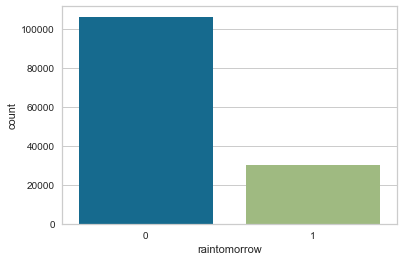

In [38]:
sns.countplot(rain['raintomorrow'])

### Confusing Matrix

In [39]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve

In [40]:
confusion_matrix(y_test, model.predict(X_test))

array([[21242,    53],
       [   51,  5952]], dtype=int64)

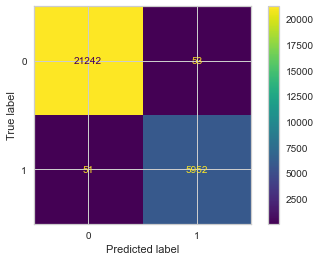

In [41]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

In [42]:
baseline_precision = precision_score(y_test, model.predict(X_test))
baseline_precision

0.9911740216486261

In [43]:
baseline_recall = recall_score(y_test, model.predict(X_test))
baseline_recall

0.991504247876062

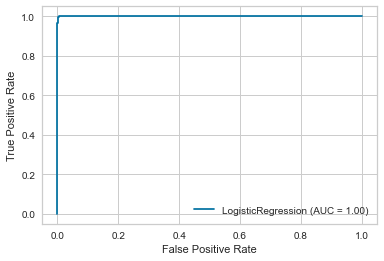

In [44]:
plot_roc_curve(model, X_test, y_test);

The AUC is also too high

In [45]:
rain_scores = pd.DataFrame({'Baseline (Log. Regression)' : [baseline_score,baseline_precision, baseline_recall]}, index=['SCORE', 'PRECISION', 'RECALL'])
rain_scores

,Baseline (Log. Regression)
SCORE,0.996190
PRECISION,0.991174
RECALL,0.991504


### Investigating further

In [46]:
X_test.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity',
       'precipitation3pm', 'precipitation9am'],
      dtype='object')

Importance of each variable used in the model:

In [47]:
list(zip(list(X.columns), list(model.coef_[0])))

[('mintemp', 0.32113933012250956),
 ('maxtemp', -0.3086560782022557),
 ('rainfall', 0.014355506314910272),
 ('humidity9am', -0.07810501165769479),
 ('humidity3pm', -0.03127969761546463),
 ('temp9am', -0.27811726012317806),
 ('temp3pm', 0.07613791649756463),
 ('amountOfRain', 15.953117440940074),
 ('temp', 0.020835414836425346),
 ('humidity', 0.0006390699822341659),
 ('precipitation3pm', -0.2032577976544183),
 ('precipitation9am', -0.10865999471966561)]

The feature 'amountOfRain' explains basically by itself the target 'raintomorrow'. We are leaking the data about tomorrow. In "real life" we woudn't have the column "RainTomorrow" if we wanted to predict if it's going to rain tomorrow.

# Baseline Model 2

In [48]:
rain.raintomorrow = rain.raintomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [49]:
rain1 = rain[(rain['raintomorrow'] == 1)]

In [52]:
rain[(rain['raintomorrow'] == 0)]

,date,location,mintemp,maxtemp,rainfall,humidity9am,humidity3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente


In [51]:
rain = pd.concat([rain0, rain1])

NameError: name 'rain0' is not defined

In [ ]:
rain.shape

##  Standardize Data

In [ ]:
rain.head()

In [ ]:
X = rain[['humidity9am', 'humidity3pm', 'temp9am', 'rainfall',
             'temp3pm', 'precipitation3pm', 'precipitation9am']]

In [ ]:
scaler = StandardScaler()

In [ ]:
X_std = scaler.fit_transform(X)

In [ ]:
X_std = pd.DataFrame(X_std, columns=X.columns)

## Logistic Regression Model Without 'raintomorrow'

In [ ]:
y = rain['raintomorrow']

In [ ]:
model = LogisticRegression(n_jobs= -1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

model.fit(X_train, y_train)
model.predict(X_train)
model.predict(X_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.predict(X_train)

In [ ]:
model.predict(X_test)

In [ ]:
model.predict_proba(X_test)

In [ ]:
baseline2_score = model.score(X_test, y_test)
baseline2_score

In [ ]:
model.score(X_train, y_train)

Without the "raintomorrow" feature we got a more realistic score.

### Confusion Matrix

In [ ]:
confusion_matrix(y_test, model.predict(X_test))

In [ ]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

### Precision X Recall

Precision:

In [ ]:
precision2_score = precision_score(y_test, model.predict(X_test))
precision2_score

Recall:

In [ ]:
recall2_score = recall_score(y_test, model.predict(X_test))
recall2_score

In [ ]:
plot_roc_curve(model, X_test, y_test)

In [ ]:
list(zip(list(X_2.columns), list(model.coef_[0])))

## Comparing Models

In [ ]:
rain_scores = scores('Baseline 2 (Log. Regression)', baseline2_score, precision2_score, recall2_score)
rain_scores

# Model 3: + Wind Dataset

## Adding Wind Dataset

In [ ]:
rain = pd.read_csv('./data/rain_data_aus.csv')
wind = pd.DataFrame()
for i in range(1,9):
    df_aux = pd.read_csv(f'./data/wind_table_0{i}.csv')
    df_aux.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    wind = pd.concat([wind,df_aux])
rain_wind =  pd.merge(rain, wind, how='left', on=['date', 'location'])

In [ ]:
#Heatmap of nulls
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain_wind.isnull(), cbar=False);

In [ ]:
#Droping columns and rows again
rain_wind.drop(['evaporation', 'sunshine', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm'], axis = 1, inplace = True)
rain_wind.dropna(axis=0, inplace=True)

In [ ]:
X = rain_wind[['rainfall', 'humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'precipitation3pm', 'precipitation9am',
        'wind_speed9am','wind_speed3pm']]

## Standardize Data

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## Logistic Regression Model + Wind Speed

In [ ]:
rain_wind.raintomorrow = rain_wind.raintomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [ ]:
y = rain_wind.raintomorrow

X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

model.fit(X_train, y_train)
model.predict(X_train)
model.predict(X_test)

In [ ]:
model.predict_proba(X_test)

In [ ]:
wind_score = model.score(X_test, y_test)
wind_score

In [ ]:
model.score(X_train, y_train)

In [ ]:
wind_precision = precision_score(y_test, model.predict(X_test))
wind_precision

In [ ]:
wind_recall = recall_score(y_test, model.predict(X_test))
wind_recall

In [ ]:
rain_scores = scores('Model 3 + Wind Speed (Log. Regression)', wind_score, wind_precision, wind_recall)
rain_scores

In [ ]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

# Model 4: Wind Direction

In [ ]:
rain_wind.head()

In [ ]:
dummies_gustdir = pd.get_dummies(rain_wind['wind_gustdir'], drop_first = True)
rain_wind = pd.concat([rain_wind, dummies_gustdir], axis = 1)
rain_wind = rain_wind.drop('wind_gustdir',axis=1)

In [ ]:
rain_wind.columns

In [ ]:
rain_winddir = rain_wind[['humidity','modelo_vigente', 'wind_gustspeed','raintomorrow', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW']]

In [ ]:
rw = rw[['humidity3pm','modelo_vigente', 'wind_gustspeed','raintomorrow', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW']]

In [ ]:
rain_winddir.loc[:, 'ENE':]

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X = rain_winddir.loc[:, 'ENE':]
y = rain_winddir[['raintomorrow']]
selector = SelectKBest(chi2, k=7)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

In [ ]:
rain_winddir = rain_wind[['humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'precipitation3pm', 'precipitation9am',
        'wind_speed9am','wind_speed3pm', 'ENE', 'ESE', 'N', 'NNW', 'NW', 'W', 'WNW']]

In [ ]:
rain_winddir

## Balanceando Datase

In [ ]:
rw1 = rain_wind[(rain_wind['raintomorrow'] == 1)].sample(20000)

In [ ]:
rw0 = rain_wind[(rain_wind['raintomorrow'] == 0)].sample(20000)

In [ ]:
rw = pd.concat([rw0, rw1])

In [ ]:
rw_r = rw.raintomorrow

In [ ]:
rw = rw[['rainfall', 'humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'precipitation3pm', 'precipitation9am',
        'wind_speed9am','wind_speed3pm', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW']]

In [ ]:
scaler = StandardScaler()

In [ ]:
X_std = scaler.fit_transform(rw)

In [ ]:
y = rw_r

X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

model.fit(X_train, y_train)
model.predict(X_train)
model.predict(X_test)

In [ ]:
model.predict_proba(X_test)

In [ ]:
dir_score = model.score(X_test, y_test)
dir_score

In [ ]:
model.score(X_train, y_train)

In [ ]:
dir_precision = precision_score(y_test, model.predict(X_test))
dir_precision

In [ ]:
dir_recall = recall_score(y_test, model.predict(X_test))
dir_recall

In [ ]:
rain_scores = scores('Model 4: Wind Direction (Log. Regression)', dir_score, dir_precision, dir_recall)
rain_scores

# Model 5: Latitude & Longitude

In [ ]:
from opencage.geocoder import OpenCageGeocode

key = '46b48d2d3d8f4acb88f582e3a83cbe77'
geocoder = OpenCageGeocode(key)

city_lat = {}
city_lng = {}

for city in rain_wind['location'].unique():
    query = f'{city}, Australia'
    results = geocoder.geocode(query)
    city_lat[city] =results[0]['geometry']['lat']
    city_lng[city] =results[0]['geometry']['lng']

In [ ]:
cities = pd.DataFrame(data=[city_lat,city_lng]).T
cities = cities.reset_index()
cities.columns= ['location','lat','lng']
rain_wind = pd.merge(left=rain_wind,right=cities,on='location')

In [ ]:
rw[['lat', 'lng']] = rain_wind[['lat' , 'lng']]

In [ ]:
rw

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(rw)

In [ ]:
y = rw_r

X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

model.fit(X_train, y_train)
model.predict(X_train)
model.predict(X_test)

In [ ]:
model.predict_proba(X_test)

In [ ]:
latlong_score = model.score(X_test, y_test)
latlong_score

In [ ]:
model.score(X_train, y_train)

In [ ]:
latlong_precision = precision_score(y_test, model.predict(X_test))
latlong_precision

In [ ]:
latlong_recall = recall_score(y_test, model.predict(X_test))
latlong_recall

In [ ]:
rain_scores = scores('Model 5: LatLong (Log. Regression)', latlong_score, latlong_precision, latlong_recall)
rain_scores

# Model 6: Data

In [ ]:
rain_wind.date = pd.to_datetime(rain_wind.date)

In [ ]:
rw['month'] = rain_wind.date.dt.month

In [ ]:
rw

In [ ]:
dummies_month = pd.get_dummies(rw['month'], drop_first = True)
rw = pd.concat([rw, dummies_month], axis = 1)
rw = rw.drop('month',axis=1)

In [ ]:
rw

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(rw)

In [ ]:
y = rw_r

X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

model.fit(X_train, y_train)
model.predict(X_train)
model.predict(X_test)

In [ ]:
model.predict_proba(X_test)

In [ ]:
month_score = model.score(X_test, y_test)
month_score

In [ ]:
model.score(X_train, y_train)

In [ ]:
month_precision = precision_score(y_test, model.predict(X_test))
month_precision

In [ ]:
month_recall = recall_score(y_test, model.predict(X_test))
month_recall

In [ ]:
rain_scores = scores('Model 6: Month (Log. Regression)', month_score, month_precision, month_recall)
rain_scores

In [ ]:
y_pred = model.predict_proba(rw)[:, 1] > 0.2
y_pred